## Предварительный анализ данных 

Перед началом работы с данными импортируем необходимые бибилиотеки: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from urllib.parse import urlencode
from scipy import stats
from scipy.stats import norm, mannwhitneyu, ttest_ind, shapiro, levene, chi2_contingency
import statsmodels.api as sm
from datetime import datetime
import statsmodels.formula.api as smf

%matplotlib inline

Создадим функцию для загрузки ссылок:

In [2]:
def download_ya_url(link):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key = link))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [3]:
final_url_groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ' 
final_url_groups_add='https://disk.yandex.ru/d/5Kxrz02m3IBUwQ' 
final_url_active_studs='https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
final_url_checks='https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [4]:
groups_link = download_ya_url(final_url_groups)
groups_add_link = download_ya_url(final_url_groups_add)
active_studs_link = download_ya_url(final_url_active_studs)
checks_link = download_ya_url(final_url_checks)

Считаем полученные файлы:

In [5]:
groups = pd.read_csv(groups_link, sep = ';') 
groups_add = pd.read_csv(groups_add_link) 
active_studs = pd.read_csv(active_studs_link)
checks = pd.read_csv(checks_link, sep = ';') 

Теперь посмотрим на каждый файл, проверим тип данных, есть ли пропущенные значения и дубликаты:

In [6]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [7]:
groups.shape


(74484, 2)

In [8]:
groups.dtypes

id      int64
grp    object
dtype: object

In [9]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [10]:
groups.duplicated().sum()

0

In [11]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [12]:
groups_add.shape

(92, 2)

In [13]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [14]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [15]:
groups_add.duplicated().sum()

0

In [16]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [17]:
active_studs.shape

(8341, 1)

In [18]:
active_studs.dtypes

student_id    int64
dtype: object

In [19]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [20]:
active_studs.duplicated().sum()

0

In [21]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [22]:
checks.shape

(541, 2)

In [23]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [24]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [25]:
checks.duplicated().sum()

0

Мы видим, что в данных нет дубликатов, пропущенных значений, и типы данных соответствуют нужным, значит, с данными все в порядке.
Можем начать исследование.

## Преобразование данных

 Для начала соединим файл про группы с дополнительным файлом, который поступил через 2 дня:

In [26]:
all_groups = pd.concat([groups, groups_add], ignore_index = True)
all_groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [27]:
all_groups.shape

(74576, 2)

Посмотрим на количество пользователей в группах:

In [28]:
all_groups.groupby('grp', as_index = False).agg({'id':'nunique'})

,grp,id
0,A,14693
1,B,59883


/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


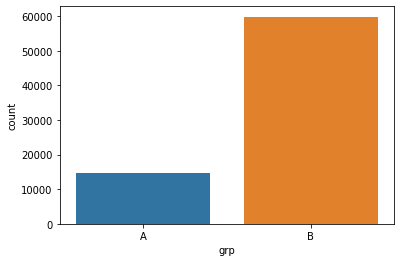

In [29]:
sns.countplot(all_groups.grp, order = ['A', 'B'])

In [30]:
# В долях это:
all_groups.grp.value_counts(normalize = True)

B    0.80298
A    0.19702
Name: grp, dtype: float64

Мы видим, что в тестовой группе (B) преобладающее количество пользователей.

Теперь объединим all_groups с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. Для этого в файле изменим название колонки-ключа:

In [31]:
all_groups = all_groups.rename(columns={'id':'student_id'})
all_groups

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


In [32]:
# Оставим только интересующих нас - активных пользователей
activ_groups = all_groups.merge(active_studs, on = 'student_id', how = 'right')

In [33]:
activ_groups.shape

(8341, 2)

In [34]:
activ_groups.isna().sum()

student_id    0
grp           0
dtype: int64

Посмотрим на распределение активных пользователей по группам:

In [35]:
activ_groups.groupby('grp', as_index = False).agg({'student_id':'nunique'})

,grp,student_id
0,A,1538
1,B,6803


/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


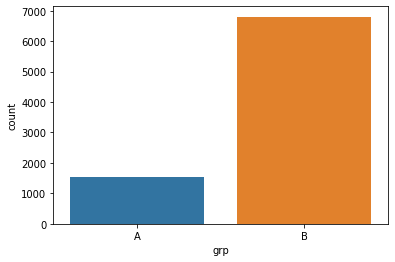

In [36]:
sns.countplot(activ_groups.grp, order = ['A', 'B'])

In [37]:
activ_groups.grp.value_counts(normalize = True)

B    0.81561
A    0.18439
Name: grp, dtype: float64

Мы видим, что соотношение пользователей в контрольной и тестовой группах в дни проведения эксперимента почти не изменилось.

Объединим новый дф с файлом checks (при этом исключим неактивных покупателей) и посмотрим на рaспределение активных пользователей, совершивших покупку, по группам:

In [38]:
check_df = activ_groups.merge(checks, on = 'student_id')
check_df

,student_id,grp,rev
0,1184303,A,1530.0000
1,3354191,B,1900.0001
2,3278734,B,1900.0000
3,720651,A,1980.0000
4,1232221,B,1900.0000
...,...,...,...
387,3890326,B,199.0000
388,1390994,A,398.0000
389,1516339,A,290.0000
390,3910596,B,597.0000


/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


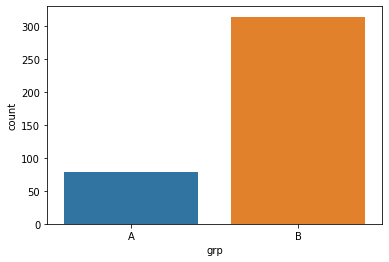

In [39]:
sns.countplot(check_df.grp, order = ['A', 'B'])

In [40]:
check_df.grp.value_counts(normalize = True)

B    0.80102
A    0.19898
Name: grp, dtype: float64

Соотношение количества пользователей в контрольной и тестовой группах по-прежнему практически не изменилось.

## Выбор метрик, постановка нулевой гипотезы и выбор критерия анализа

Нам необходимо сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей. Для оценки пользы новой механики оплаты выбираем метрики. Показательными в данном случае видятся три основные метрики: конверсия с посещения сайта в покупку, средний доход с покупателя и средний доход с пользователя. Сформулируем гипотезы: Н0 - новая механика не влияет на 1) конверсию в покупку, 2) ARPPU и 3) ARPU. Н1 - новая механика оплаты влияет на эти метрики. Проверим:

1) Так как мы имеем дело с номинативными переменными, чтобы сравнить конверсию в покупки в группах, используем критерий Хи-квадрат (условия применения у нас соблюдены). Создадим дф с со всеми активными пользователями и покупками. Покупку обозначим цифрой 1, пропущенные значения заменим на ноль:

In [41]:
checks['purchase'] = 1
checks.head()

,student_id,rev,purchase
0,1627,990.0,1
1,3185,690.0,1
2,25973,690.0,1
3,26280,690.0,1
4,100300,990.0,1


In [42]:
all_df = activ_groups.merge(checks, on = 'student_id', how = 'left').fillna(0)

In [43]:
all_df['purchase'] = all_df['purchase'].astype('int')
all_df

,student_id,grp,rev,purchase
0,581585,A,0.0,0
1,5723133,A,0.0,0
2,3276743,B,0.0,0
3,4238589,A,0.0,0
4,4475369,B,0.0,0
...,...,...,...,...
8336,1794344,B,0.0,0
8337,296883,B,0.0,0
8338,3598448,B,0.0,0
8339,3610547,B,290.0,1


Создадим таблицу сопряженности:

In [44]:
table = pd.crosstab(all_df.grp, all_df.purchase)
table

purchase,0,1
grp,,
A,1460,78
B,6489,314


Посмотрим на значения конверсии по группам:

In [45]:
round(table[1] / (table[0] + table[1]) *100, 3)

grp
A    5.072
B    4.616
dtype: float64

Мы видим, что в контрольной группе процент сделавших покупку несколько выше. Проверим, является ли эта разница статистически значимой. Проведем тест и выведем результат:

In [281]:
stat, p, dof, expected = chi2_contingency(table)
prob = 0.95
alpha = 1 - prob
if p <= alpha:
    print("Отклоняем Н0. Новая механика влияет на конверсию в покупку.")
else:
     print("НЕ отклоняем Н0: новая механика не влияет на конверсию в покупку.")

НЕ отклоняем Н0: новая механика не влияет на конверсию в покупку.


Таким образом, получаем результат, что разница в конверсии с посещения сайта в покупку в контрольной и тестовой группах не стат. значима, и что новая механика оплаты не влияет на решение пользователя совершить покупку.  

2) Чтобы выбрать критерий для сравнения среднего дохода с платящего пользователя в двух группах, посмотрим на распределение покупок по группам на графиках:

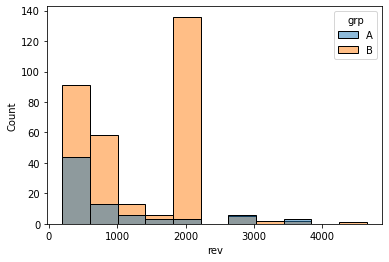

In [282]:
sns.histplot(x = 'rev', hue = 'grp', data = check_df)

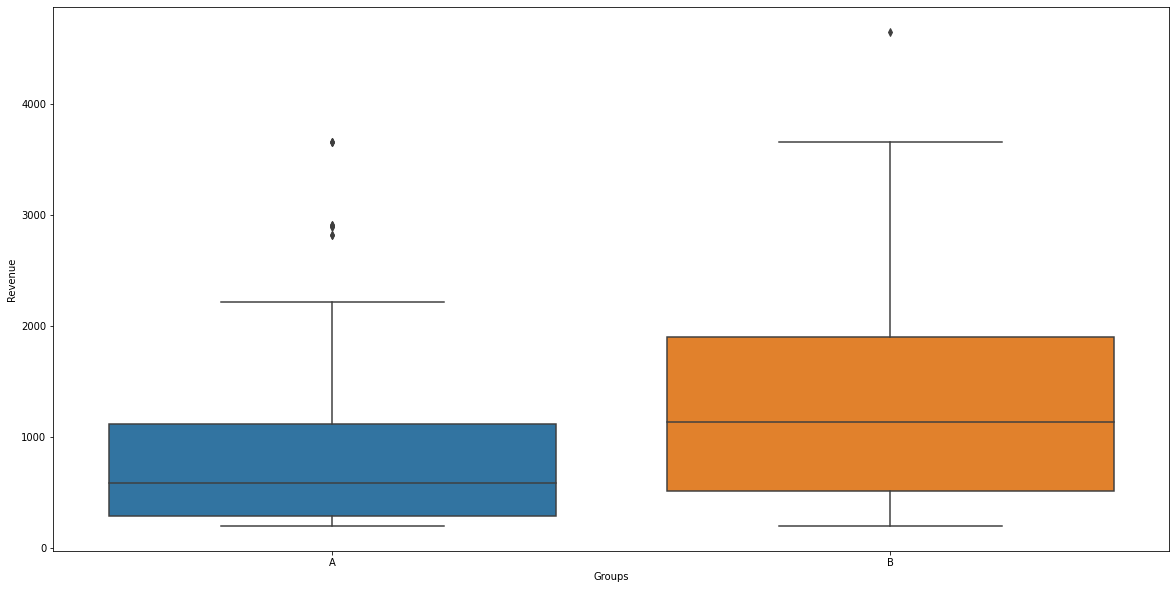

In [283]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='grp', y='rev', data= check_df)
plt.xlabel('Groups')
plt.ylabel('Revenue')
plt.show()

Как мы видим, в наших данных распределение значений в обеих группах ненормально и есть выбросы. 

Создадим выборки с контрольной и тестовой группами и проведем тест на нормальность распределения:

In [284]:
control = check_df[check_df.grp == 'A'].rev
test = check_df[check_df.grp == 'B'].rev

In [285]:
shapiro(control)

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

In [286]:
shapiro(test)

ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)

Тест подтверждает, что распределение в обеих группах далеко от нормального, и пренебречь этим мы не можем, так как количество наблюдений ощутимо меньше 500. Значит, Т-тест нам не подходит. Результат критерия Манна-Уитни сложно интерпретировать для бизнеса, поэтому мы используем для анализа метод bootstrap: 

In [287]:
def get_bootstrap(
    group_A, 
    group_B, 
    boot_iter = 2000, 
    statistic = np.mean, 
    bootstrap_conf_level = 0.95 
):
    boot_len = max(len(group_A), len(group_B))
    df = []
    for i in range(boot_iter): 
        samples_A = group_A.sample(
            boot_len,
            replace=True 
        ).values
        
        samples_B = group_B.sample(
            boot_len,
            replace=True
        ).values
        
        df.append(statistic(samples_A - samples_B))
        
    pd_df = pd.DataFrame(df)
    
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_df.quantile([left_quant, right_quant])
    
    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(df),
        scale = np.std(df))
    
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(df),
        scale = np.std(df))
    
    p_value = min(p_1, p_2) * 2
    return {'df': df,
            'ci': ci,
            'p_value': p_value}

In [288]:
bootstrap = get_bootstrap(control, test, boot_iter = 2000)

In [289]:
bootstrap['ci']

,0
0.025,-460.207098
0.975,-199.181697


In [290]:
bootstrap['p_value']

1.383457908782726e-06

Значение p-value сильно меньше 0.05 и 0  не входит в доверительные интервалы, значит, мы получили стат. значимые различия в наших группах по ARPPU и можем отклонить нулевую гипотезу, что новая механика оплаты не влияет на эту метрику. Посмотрим на эти различия через описательную статистику (значение mean = ARPPU):

In [291]:
control.describe()

count      78.000000
mean      933.589744
std       919.932711
min       199.000000
25%       290.000000
50%       585.000000
75%      1114.750000
max      3660.000000
Name: rev, dtype: float64

In [292]:
test.describe()

count     314.000000
mean     1257.878992
std       790.864254
min       199.000000
25%       511.750000
50%      1140.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

Рассчитаем разницу в процентах:

In [293]:
A = control.sum() / check_df.query('grp == "A"').student_id.nunique()
B = test.sum() / check_df.query('grp == "B"').student_id.nunique()

In [294]:
print('ARPPU тестовой группы больше на', round(((B - A) / A * 100), 1), '%')

ARPPU тестовой группы больше на 34.7 %


Мы видим, что доход с покупателя в тестовой группе выше, чем в контрольной, почти на 35%!

3) Теперь сравним ARPU в двух группах:

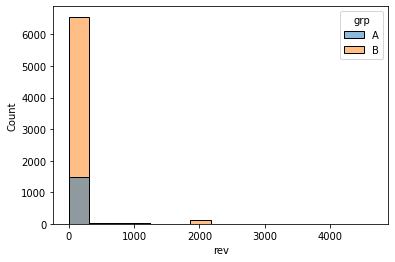

In [295]:
sns.histplot(x = 'rev', hue = 'grp', data = all_df)

На гистограмме видно, что очень малое количество пользователей совершили покупки в дни эксперимента. Cоздадим выборки по группам и проведем анализ методом bootstrap:

In [296]:
control1 = all_df[all_df.grp == 'A'].rev
test1 = all_df[all_df.grp == 'B'].rev

In [297]:
bootstrap = get_bootstrap(control1, test1, boot_iter = 2000)

In [298]:
bootstrap['ci']

,0
0.025,-21.078135
0.975,-0.869374


In [299]:
bootstrap['p_value']

0.036353611243945115

Несмотря на то, что нулевое значение довольно близко к доверительному интервалу, оно все же не входит, и значение p-value  ниже 5% позволяет нам утверждать, что различие по ARPU в группах стат. значимо. Следовательно, новая механика оплаты влияет на средний доход с пользователя. Посмотрим как:

In [300]:
control1.describe()

count    1538.000000
mean       47.347204
std       290.490632
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      3660.000000
Name: rev, dtype: float64

In [301]:
test1.describe()

count    6803.000000
mean       58.058798
std       313.770201
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      4650.000000
Name: rev, dtype: float64

По показателю mean видно, что ARPU в тестовой группе выше на 11 единиц, чем в контрольной!

## Вывод  

Исходя из того, что в тестовой группе (В) средний доход с покупателя возрос почти на 35%, а средний  доход с пользователя - на 11 единиц, рекомендуем запустить новую механику оплаты на всех пользователей.

# Функции

1. Функция, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Функция, которая будет строить графики по получаемым метрикам.

## 1

In [304]:
def add_info(df, add_df):
    
    # Заменим заголовки в дополнительном файле
    add_df = add_df.rename(columns = {add_df.columns[0]: 'id',   
                   add_df.columns[1]: 'grp'})
    
    # Соединим дф-ы с группами
    new_df = pd.concat([df, groups_add]) 
    
    # Переименуем колонки
    active_studs.rename(columns={'student_id': 'id'}, inplace=True)
    checks.rename(columns={'student_id': 'id'}, inplace=True)
   
    # Создадим дф для расчета CR в покупку
    active_grp = active_studs.merge(new_df, on='id')  

    checks_new = checks.copy()
    checks_new['purchase'] = 1
    
    CR_df = active_grp.merge(checks_new, on = 'id', how = 'left')
    CR_df = CR_df.fillna(0)
    CR_df['purchase'] = CR_df['purchase'].astype('int')
    
    # Посчитаем значения СR в покупку для групп
    A = CR_df[CR_df['grp'] == 'A']
    B = CR_df[CR_df['grp'] == 'B']
    
    A_1 = A.purchase.sum()
    A_0 = A.purchase.size - A.purchase.sum()
    B_1 = B.purchase.sum()
    B_0 = B.purchase.size - B.purchase.sum()
    
    CR_A = round(A_1 / (A_1 + A_0) * 100, 2)
    CR_B = round(B_1 / (B_1 + B_0) * 100, 2)
    
    # Создадим дф для расчета ARPPU
    checks_df = checks.copy()
    active_checks = active_grp.merge(checks_df, on = 'id')
    
    # Посчитаем значения ARPPU для групп
    ARPPU_A = active_checks[active_checks['grp'] == 'A']
    ARPPU_B = active_checks[active_checks['grp'] == 'B']
    ARPPU_A_res = round(ARPPU_A.rev.sum() / ARPPU_A.id.nunique(), 2)
    ARPPU_B_res = round(ARPPU_B.rev.sum() / ARPPU_B.id.nunique(), 2)
    
    # Создадим дф для расчета ARPU
    ARPU_df = new_df.merge(active_checks, on = ['id', 'grp'], how = 'left')
    ARPU_df = ARPU_df.fillna(0)
    
    # Посчитаем ARPU для групп
    ARPU_A = ARPU_df[ARPU_df['grp'] == 'A']
    ARPU_B = ARPU_df[ARPU_df['grp'] == 'B']
    ARPU_A_res =  round(ARPU_A.rev.sum() / ARPU_A.id.nunique(), 2)
    ARPU_B_res =  round(ARPU_B.rev.sum() / ARPU_B.id.nunique(), 2)
    
    print(f'Конверсия с посещения сайта в покупку для контрольной группы (А) составляет: {CR_A} %')
    print(f'Конверсия с посещения сайта в покупку для тестовой группы (В) составляет: {CR_B} %' + '\n')
    print(f'ARPPU для контрольной группы (А): {ARPPU_A_res}')
    print(f'ARPPU для тестовой группы (B): {ARPPU_B_res}'+'\n')
    print(f'ARPU для контрольной группы (А): {ARPU_A_res}')
    print(f'ARPU для тестовой группы (В): {ARPU_B_res}' + '\n')
    
    return {'Group': ['A', 'B'],
            'CR': [CR_A, CR_B],
            'ARPPU': [ARPPU_A_res, ARPPU_B_res],
            'ARPU': [ARPU_A_res, ARPU_B_res]} 

In [305]:
metrics = add_info(groups, groups_add)

Конверсия с посещения сайта в покупку для контрольной группы (А) составляет: 5.07 %
Конверсия с посещения сайта в покупку для тестовой группы (В) составляет: 4.62 %

ARPPU для контрольной группы (А): 933.59
ARPPU для тестовой группы (B): 1257.88

ARPU для контрольной группы (А): 4.96
ARPU для тестовой группы (В): 6.6



## 2

In [306]:
# Построим барплоты с показателями на основании данных из предыдущей функции
def graph_by_metrics(df):  
         
    plt.figure(figsize=(20, 9)) 
    graph_df = pd.DataFrame(df)
    
# Показатели CR в покупку   
    plt.subplot(1, 3, 1)
    plots = sns.barplot(x = 'Group', y = 'CR', data = graph_df, palette='hls')
    for bar in plots.patches:
        plots.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
    plots.axes.set_title('CR', fontsize=16)
    plots.set_xlabel('Group', fontsize=12)
    plots.set_ylabel('CR, %', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
# Показатели ARPPU    
    plt.subplot(1, 3, 2)
    plots = sns.barplot(x = 'Group', y = 'ARPPU', data = graph_df, palette='hls')
    for bar in plots.patches:
          plots.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
    plots.axes.set_title('ARPPU', fontsize=16)
    plots.set_xlabel('Group', fontsize=12)
    plots.set_ylabel('ARPPU', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12) 
    
# Показатели ARPU
    plt.subplot(1, 3, 3)
    plots = sns.barplot(x = 'Group', y = 'ARPU', data = graph_df, palette='hls')
    for bar in plots.patches:
          plots.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
    plots.axes.set_title('ARPU', fontsize=16)
    plots.set_xlabel('Group', fontsize=12)
    plots.set_ylabel('ARPU', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)    
       

Конверсия с посещения сайта в покупку для контрольной группы (А) составляет: 5.07 %
Конверсия с посещения сайта в покупку для тестовой группы (В) составляет: 4.62 %

ARPPU для контрольной группы (А): 933.59
ARPPU для тестовой группы (B): 1257.88

ARPU для контрольной группы (А): 4.96
ARPU для тестовой группы (В): 6.6



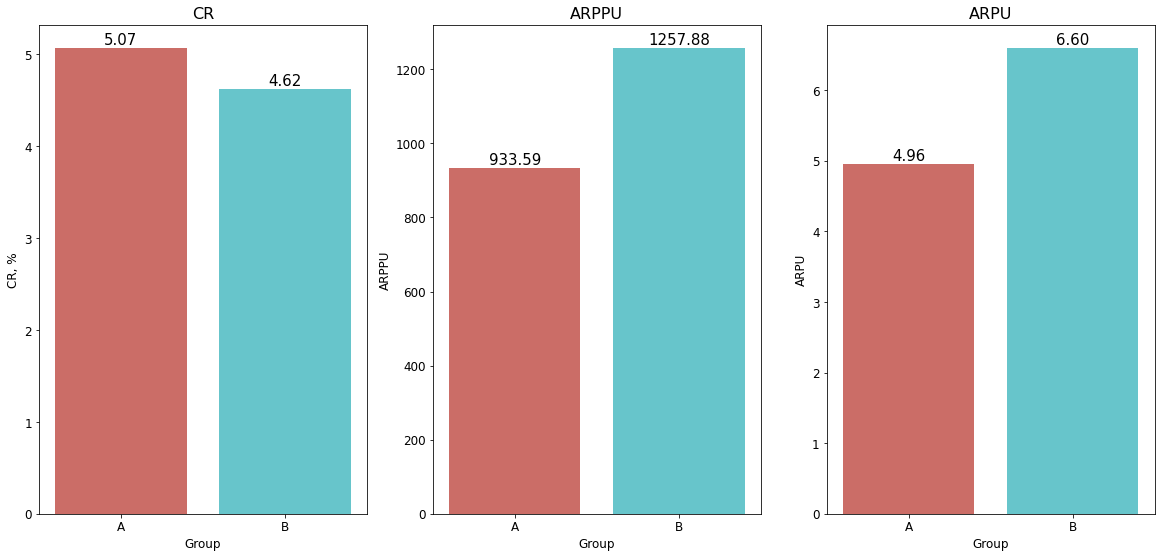

In [307]:
graph_by_metrics(add_info(groups, groups_add))